# Setup of burner combustion conditions

In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from majordome.simulate.combustion import BurnerFlowRatesCalculator
from majordome.simulate.combustion import CombustorPSR
import cantera as ct
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
ct.add_directory("../databases/kinetics/")

In [61]:
fuel = {
    "CH4":  0.9219,
    # "C2H6": 0.0427,
    # "C3H8": 0.0064,
    # "CO2":  0.0095,
    # "N2":   0.0195
}

oxid = {
    "O2":  0.995,
    # "H2O": 0.005
}

oxid = {
    "N2":  0.78,
    "O2":  0.21,
    # "H2O": 0.005
}

phi = 0.993
tau_max = 0.01

In [62]:
imposing_power = True

hdot = 500.0
mech = "gri30.yaml"

calc = BurnerFlowRatesCalculator(mech)
calc.set_states(phi, fuel, oxid, basis="mole")

if imposing_power:
    fuel_ndot, oxid_ndot = calc.get_mole_flow_rates(hdot)
else:
    fuel_ndot, oxid_ndot = calc.get_mole_flow_from_fuel_flow(1.0)

fuel_mdot, oxid_mdot = calc.mole_to_mass_flow(fuel_ndot, oxid_ndot)
mdot = fuel_mdot + oxid_mdot

comb = CombustorPSR(mech)
comb.set_states(phi, fuel, oxid, basis="mole")
comb.simulate_with_mass_flow(mdot)

hdot = comb.states.heat_release_rate / 1000.0
hdot

oxid_ndot / fuel_ndot, hdot

(9.49503668536904, array([431.89798664]))

In [63]:
# gas = ct.Solution("gri30.yaml")

# # Set reactants state
# gas.TPX = 298, 101325, fuel
# h1 = gas.enthalpy_mass
# Y_CH4 = gas["CH4"].Y[0]  # returns an array, of which we only want the first element

# # set state to complete combustion products without changing T or P
# gas.TPX = None, None, "CO2:1, H2O:2"
# h2 = gas.enthalpy_mass

# LHV = -(h2 - h1) / Y_CH4 / 1e6
# print(f"LHV = {LHV:.3f} MJ/kg")

In [64]:
comb.states.to_pandas()[["Y_CO", "Y_CO2", "Y_H2O"]]

,Y_CO,Y_CO2,Y_H2O
0,0.008979,0.137614,0.120733


In [28]:
def test_mechanism(mech, fuel):
    """ """
    tau_min = 0.0001 * tau_max
    comb = CombustorPSR(mech)
    comb.set_states(phi, fuel, oxid, basis="mole")
    comb.to_steady_state(tau_max, tau_min=tau_min, tau_dec=0.8)
    comb.plot(
        tau_scale=1000,
        xlim=(tau_min * 1000, tau_max * 1000),
        ax1_ylim=(1e+01, 1e+06),
        ax2_ylim=(1e-07, 1e+00),
        ax3_ylim=(0, 4000),
        loc=1
    )
    plt.show()
    return comb


def test_excluding_species(mech, spec_list=[]):
    """ """
    x_fuel_local = {**fuel}

    for spec in spec_list:
        if spec in x_fuel_local:
            del x_fuel_local[spec]

    comb = test_mechanism(mech, x_fuel_local)
    return comb


def test_gri30():
    """ """
    mech = "gri30.yaml"
    comb = test_excluding_species(mech, spec_list=[])
    return comb


def test_lu30_gri30():
    """ """
    mech = "Lu_2008_CH4_sk30/lu30_gri30.cti"
    comb = test_excluding_species(mech, spec_list=["C3H8"])
    return comb


def test_zhukov23_gri30():
    """ """
    mech = "Zhukov_2018_sk23/zhukov23_gri30.cti"
    comb = test_excluding_species(mech, spec_list=["C3H8"])
    return comb


def test_2s_ch4_bfer():
    """ """
    mech = "Methane_Low_Order/2S_CH4_BFER.cti"
    comb = test_excluding_species(mech, spec_list=["C2H6", "C3H8"])
    return comb

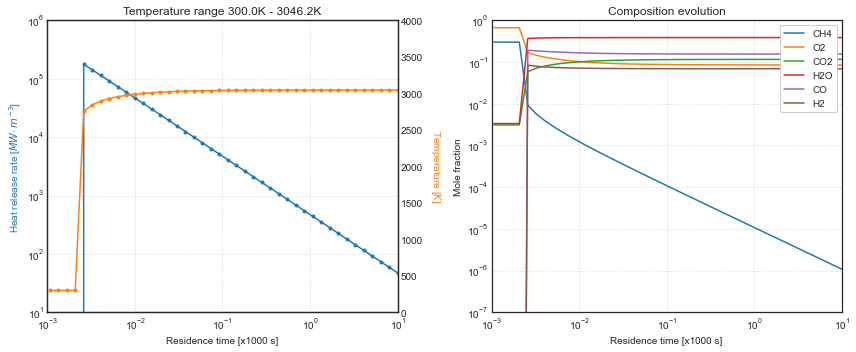

In [29]:
comb = test_gri30()

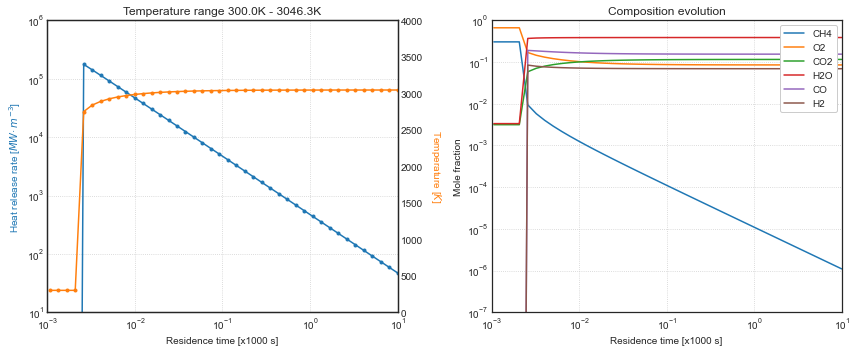

In [30]:
comb = test_lu30_gri30()

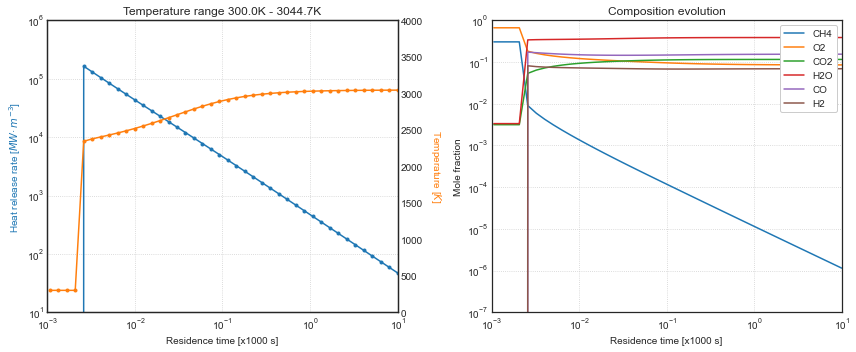

In [31]:
comb = test_zhukov23_gri30()

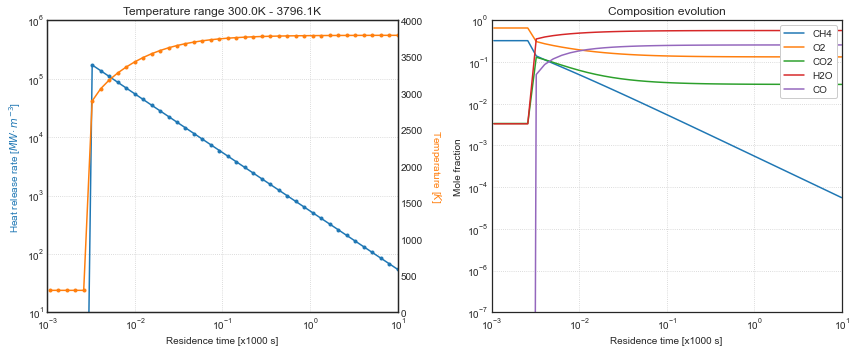

In [32]:
comb = test_2s_ch4_bfer()